In [54]:
import os
import sys
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import rich
import gseapy as gp
import warnings

from IPython.display import display
from rich.panel import Panel
from gseapy import gseaplot
from statannotations.Annotator import Annotator
from pathlib import Path
from scBTF import SingleCellTensor, SingleCellBTF, FactorizationSet, Factorization
from rich.console import Console

%config InlineBackend.figure_formats = ['png2x']
console = Console()
sc.logging.print_header()
sc.settings.njobs = 32
print()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7



## 1. Load Config and Data

In [46]:
CONFIG_FILE = '.config_ipynb'

if os.path.isfile(CONFIG_FILE):
    with open(CONFIG_FILE) as f:
        sys.argv = f.read().split()
else:
    sys.argv = ['stub.py']
parser = argparse.ArgumentParser()
parser.add_argument("--adata_path", help="path to adata object, expects log normalized X")
parser.add_argument("--consensus_factorization_path", help="path to scBTF factorization result, .pkl format")
parser.add_argument("--rank", type=int, help="rank")
parser.add_argument("--factor", type=int, help="factor")

args = parser.parse_args()

rich.print(vars(args))
globals().update(vars(args))

{
    'adata_path': '/home/dchafamo/final/data/combined_dataset_final_v2.h5ad',
    'consensus_factorization_path': '/home/dchafamo/scBTF/results/hgnc_hals_consensus_factorization.pkl',
    'rank': 24,
    'factor': 1
}

In [10]:
reconstructed_all = FactorizationSet.load(consensus_factorization_path)
reconstructed_all.__str__()

Single cell factorization object with the following params:
        Tensor size 15 x 15 x 17147
        Ranks: [16, 24, 20]

''

## 2. Summary plot of factor

────────────────────────────────────────────────── Summary Plot ───────────────────────────────────────────────────

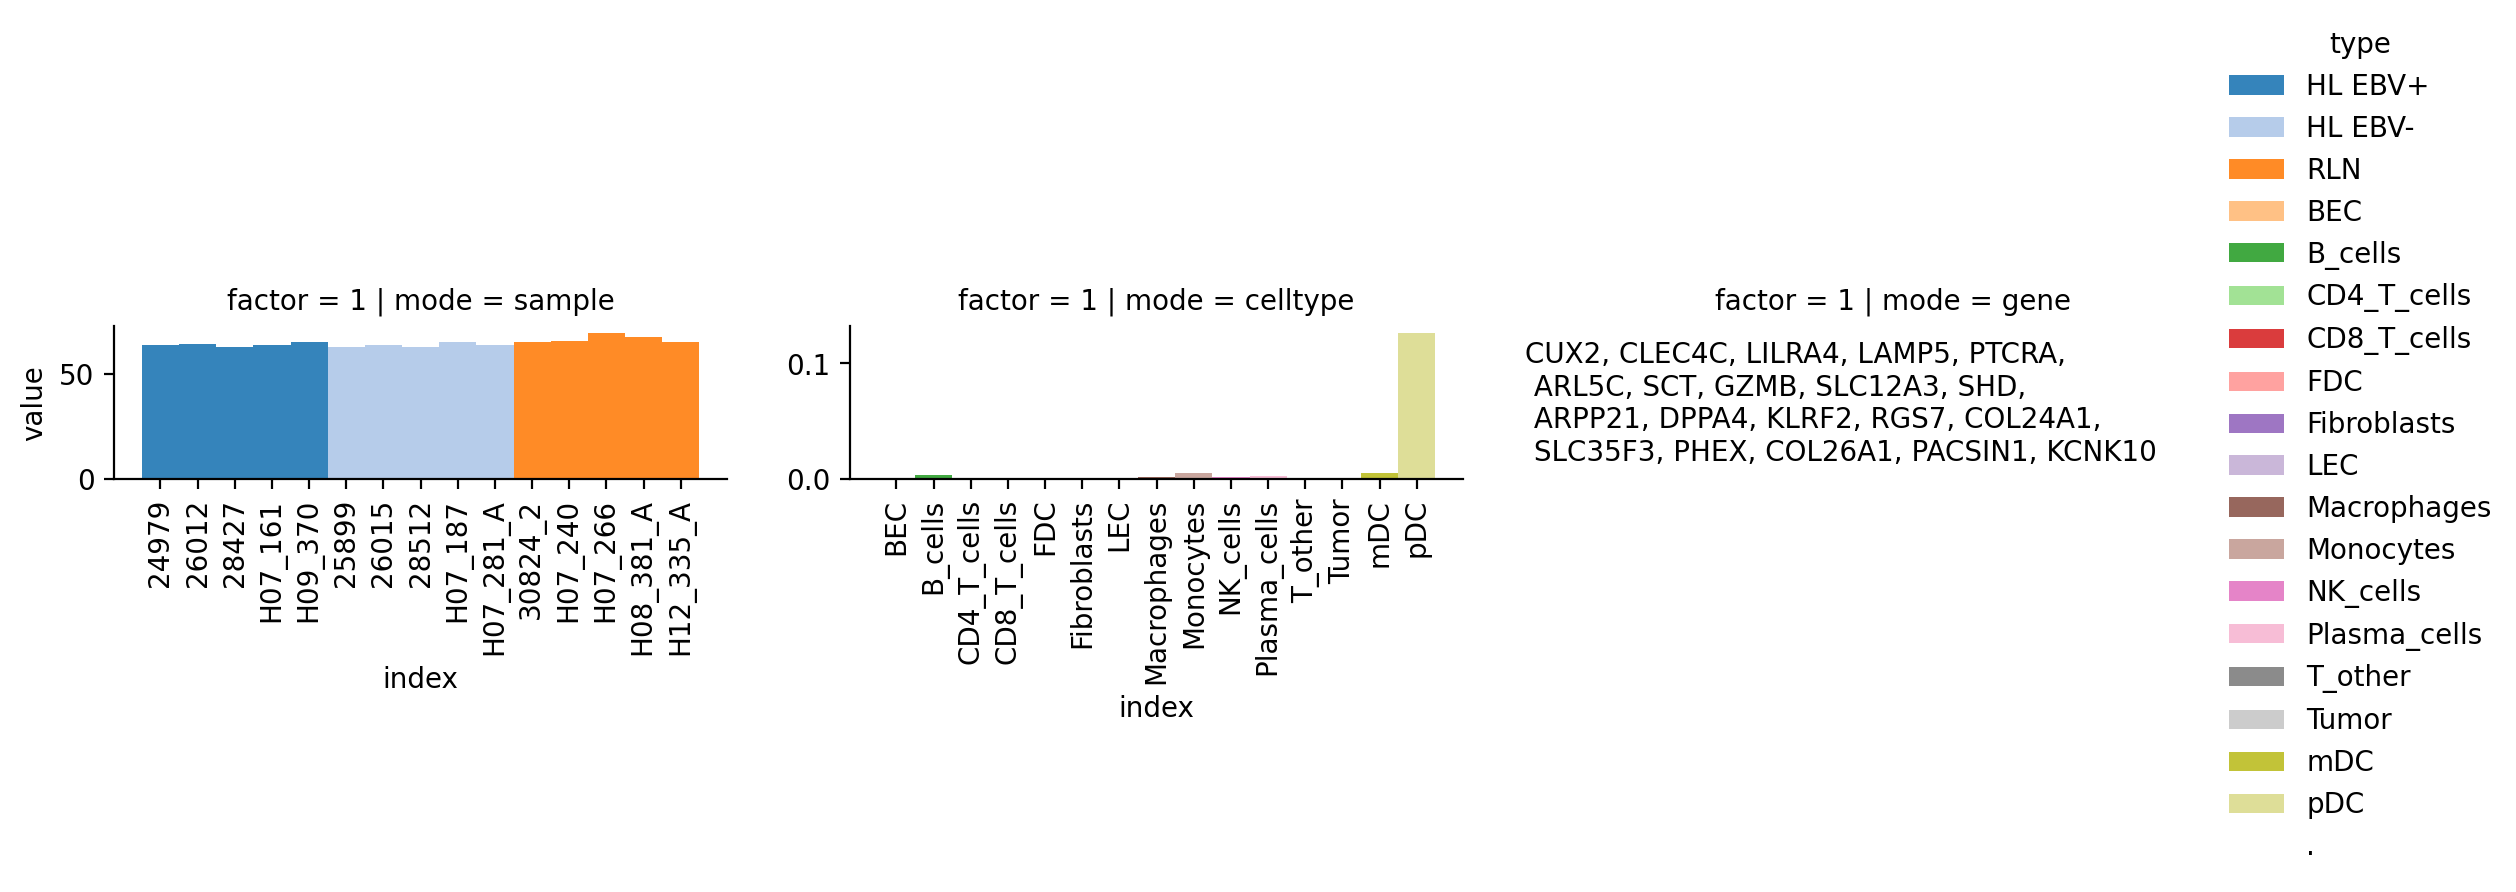

In [47]:
"""
    
    Factor loadings for samples in the first panel and celltypes in the second panel. 
    Third panel gives the gene program extracted from the gene loadings of the factor
    
"""
console.rule("[bold red]Summary Plot")

fig = reconstructed_all.plot_components(
    rank=rank, 
    restart_index=0, 
    threshold = 0.7,
    entropy = 1, 
    eps = 0, 
    sort_by = 'other',
    plot_erichment_terms=False, 
    factors = [str(factor)],
    normalize_gene_factors=True, 
    title=False
)

In [58]:
# console.rule("[bold red]GEP Score on UMAP ")

# adata = sc.read(adata_path)
# gene_programs = reconstructed_all.get_gene_programs(
#     rank, 0, normalize_gene_factors=True, threshold=0.6, sort_by='other', entropy=1, eps=0
# )
# sc.pp.scale(adata, zero_center=False)
# sc.tl.score_genes(adata, gene_programs[factor], score_name = f'rank_{rank}_factor_{factor}', use_raw=False)
# with warnings.catch_warnings() and plt.rc_context({'figure.figsize': (8, 8)}):
#     warnings.simplefilter("ignore")
#     sc.pl.umap(adata, color=['cell_types_level_3', f'rank_{rank}_factor_{factor}'], wspace=0.1, add_outline=False, cmap='magma',
#                legend_loc='on data', size=5, palette='tab20',legend_fontsize=8, legend_fontoutline=2,frameon=False)

─────────────────────────────────── Sample Factor to Sample Feature Correlation ───────────────────────────────────

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HL EBV+ vs. HL EBV-: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.300e+01
HL EBV- vs. RLN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.587e-02 U_stat=1.000e+00
HL EBV+ vs. RLN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.587e-02 U_stat=1.000e+00


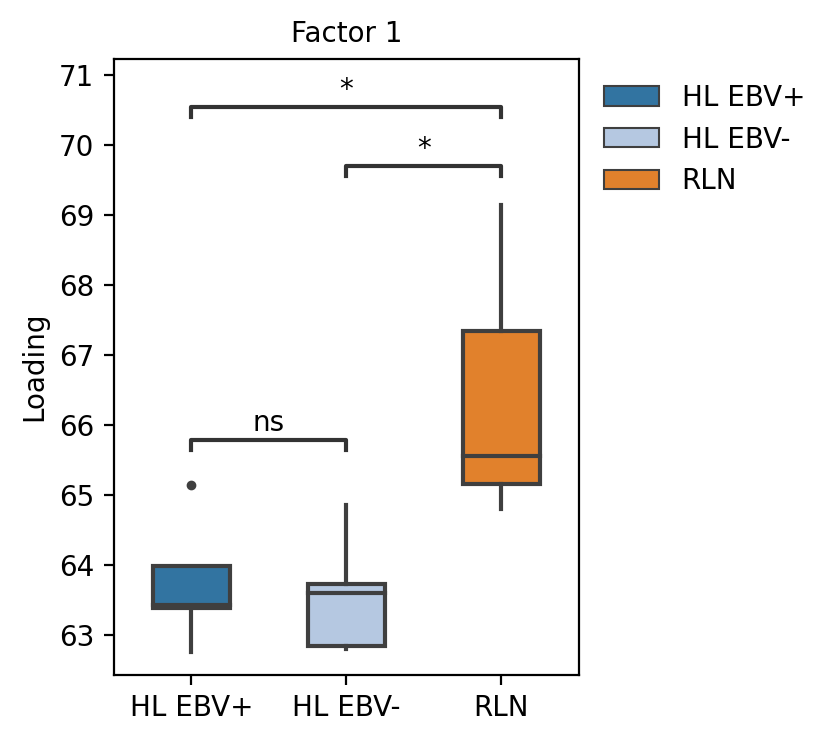

In [49]:
console.rule("[bold red]Sample Factor to Sample Feature Correlation")

fig = reconstructed_all.sample_factor_correlation(
    rank = rank, restart_index = 0, 
    x = "sample_type", y = factor, 
    order = ["HL EBV+", "HL EBV-", "RLN"], 
    pairs = [("HL EBV+", "HL EBV-"), ("HL EBV+", "RLN"), ("HL EBV-", "RLN")]
)
plt.show()

────────────────────────────────────────── Normalized but Unfiltered GEP ──────────────────────────────────────────

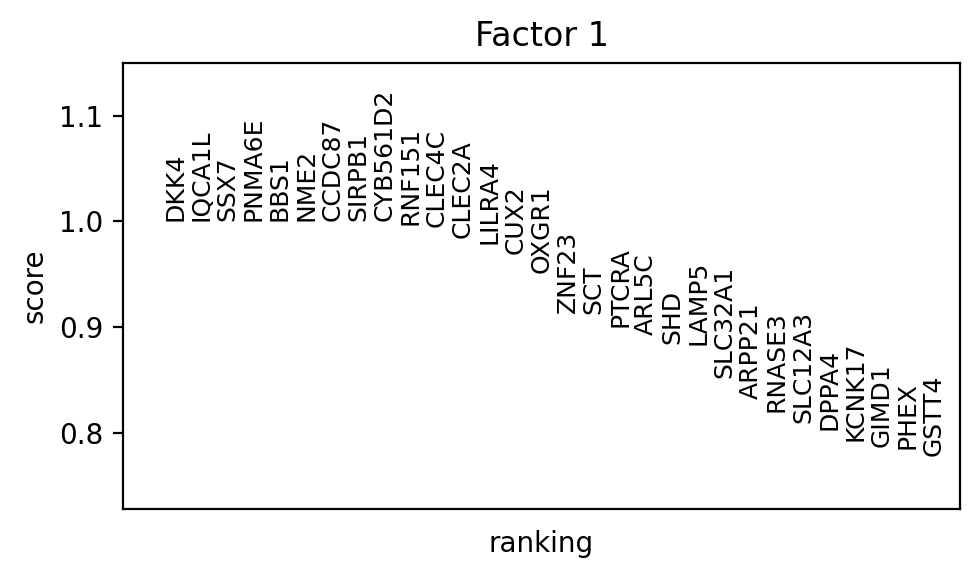

In [50]:
console.rule("[bold red]Normalized but Unfiltered GEP")

fig, factors = reconstructed_all.gene_factor_elbow_plots(
    rank=24, restart_index=0, factor_index=factor, num_genes=30, normalize=True, fontsize=9, figsize=(5,3))


────────────────────────────────── Validating of top genes using raw expression ───────────────────────────────────

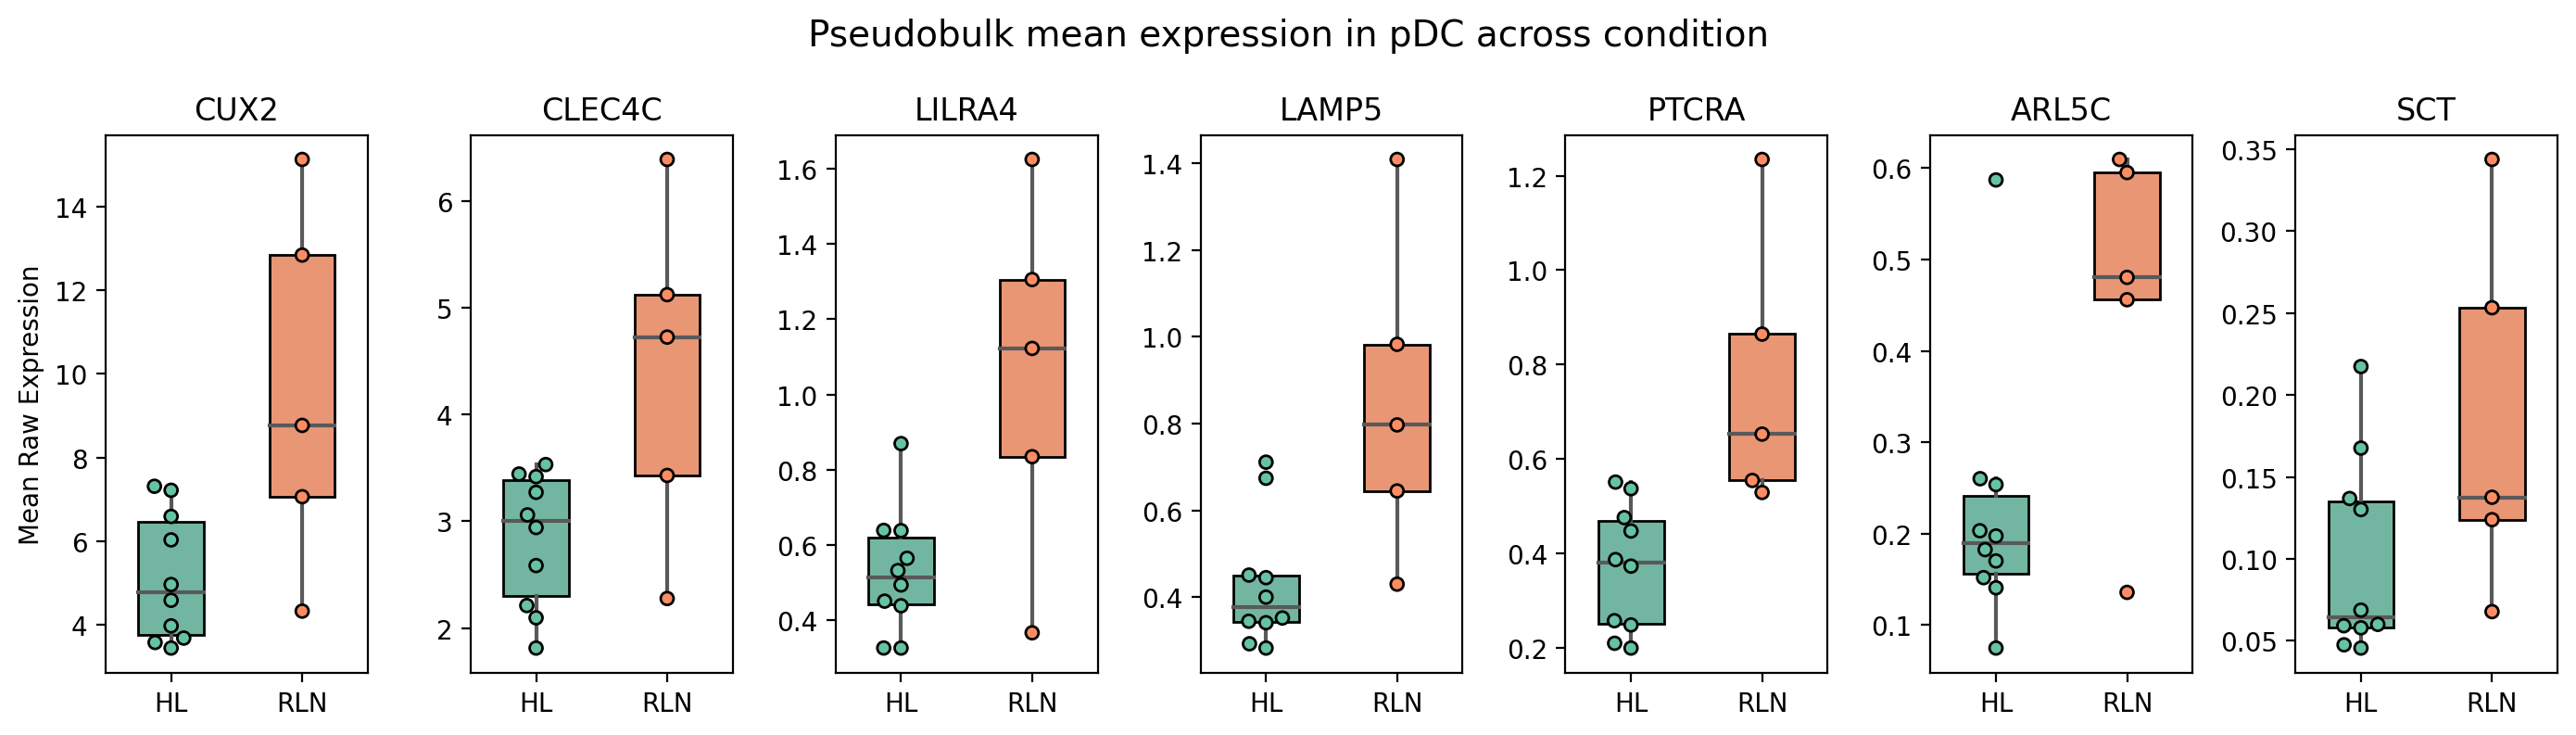

In [51]:
console.rule("[bold red]Validating of top genes using raw expression")

threshold = 0.3

factorization = reconstructed_all.get_factorization(rank=rank, restart_index=0)
ct_factor = factorization.celltype_factor['mean'].numpy()[:,factor]

ctype = reconstructed_all.sc_tensor.celltype_list[ct_factor.argmax()]

fig, axs = plt.subplots(1,7,figsize=(14, 4))
xlab = None
for ax, gene in zip(axs, gene_programs[factor][:7]):
    FactorizationSet.case_control_1v1(
        adata=adata, 
        gene=gene, 
        celltype=ctype, 
        iv='condition', 
        donor_label='donor', 
        celltype_label='cell_types_level_3', 
        ax=ax,
        title=gene,
        xlab=xlab
    )
    xlab = ''
fig.suptitle(f"Pseudobulk mean expression in {ctype} across condition", fontsize=14)
fig.tight_layout()
plt.show()

In [52]:
console.rule("[bold red]Gene Set Enrichment Analysis")

for gset in ['GO_Biological_Process_2021']:
    display(gp.enrichr(
        gene_list=gene_programs[factor], 
        gene_sets=gset, 
        organism='human', 
        background=reconstructed_all.sc_tensor.gene_list, 
        outdir=None
    ).results.head(5).style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='.col1', props=[('min-width', '300px')])]))

────────────────────────────────────────── Gene Set Enrichment Analysis ───────────────────────────────────────────

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,regulation of interferon-alpha production (GO:0032647),4/25,0.000045,0.032815,0,0,24.043676,240.730918,PTPRS;IRF7;TLR7;LILRA4
1,GO_Biological_Process_2021,cellular response to purine-containing compound (GO:0071415),3/10,0.000059,0.032815,0,0,53.793852,523.895326,TRPM2;P2RY6;P2RY1
2,GO_Biological_Process_2021,inorganic cation transmembrane transport (GO:0098662),10/274,0.000078,0.032815,0,0,4.910446,46.442563,SLC12A3;TRPM2;LRRC26;KCNK10;KCNH8;SCN9A;KCNK17;KCNK1;MCOLN2;SLC9C2
3,GO_Biological_Process_2021,potassium ion transmembrane transport (GO:0071805),7/139,0.000135,0.040409,0,0,6.786157,60.476213,LRRC26;SLC12A3;KCNK10;KCNH8;KCNK17;KCNK1;SLC9C2
4,GO_Biological_Process_2021,regulation of cytokine production (GO:0001817),7/150,0.000216,0.040409,0,0,6.260648,52.844748,SCAMP5;IRF7;KLRF2;PLD4;IRF8;ICOSLG;CCR2
